## Reuters dataset

In [1]:
import plaidml.keras
plaidml.keras.install_backend()

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

C:\Users\alikr\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\alikr\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
len(train_data), len(test_data)

(8982, 2246)

In [4]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

### Decoding newswires back to text

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [6]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [7]:
train_labels[10]

3

###  Encoding the data

#### One-hot-encoding

In [8]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [9]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
    one_hot_train_labels = to_one_hot(train_labels)
    one_hot_test_labels = to_one_hot(test_labels)
    
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

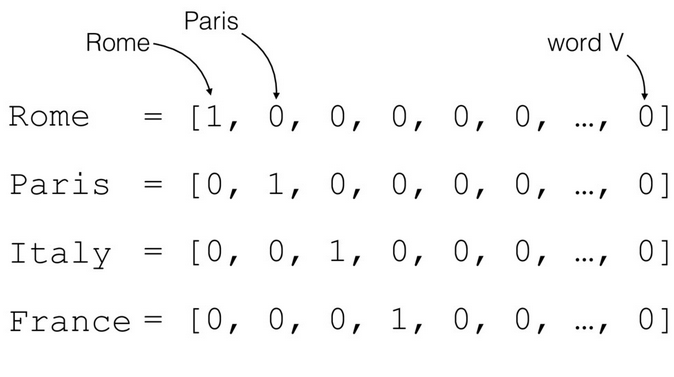

### enumerate() 
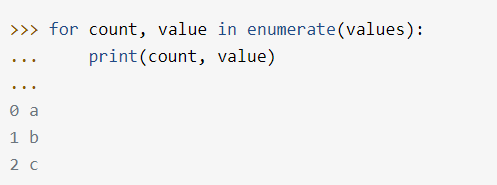

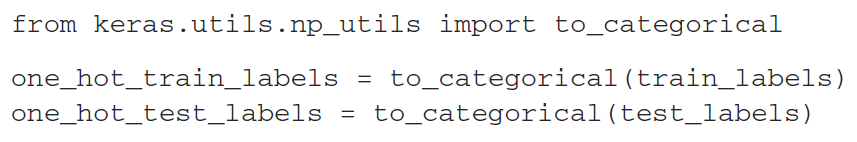

OHE'nin 6.1'de daha detaylı açıklaması var

In [10]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
x_train.shape

(8982, 10000)

## Building your network

Mnist veri setinde 10 sınıf vardı. Bunu göz önüne alarak bilginin kaybolmaması için her katmana 16 nöron verildi ama reuters veri setinde 46 sınıf bulunduğundan 16 nöron kullanılması verinin kaybolmasına neden olabilir. Bu nedenle 64 nöron kullanacağız.

In [12]:
len(set(train_labels))

46

In [13]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

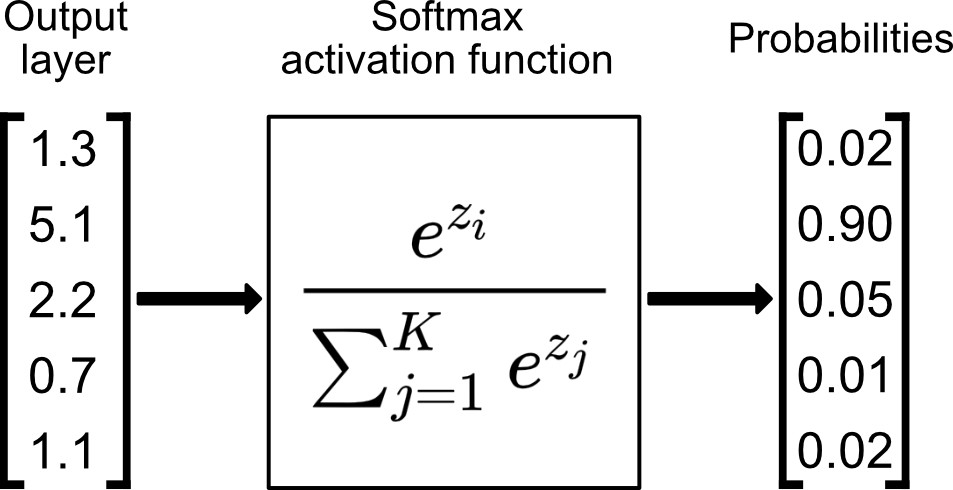

## Compiling the model

In [14]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Setting aside a validation set

In [15]:
len(x_train)

8982

Test için trainden veri alıyoruz

In [16]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## Training the model

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 32ms/step - loss: 2.6805 - accuracy: 0.4654 - val_loss: 1.7687 - val_accuracy: 0.6220
Epoch 2/20
16/16 [==============================] - 0s 21ms/step - loss: 1.4548 - accuracy: 0.6874 - val_loss: 1.3100 - val_accuracy: 0.7060
Epoch 3/20
16/16 [==============================] - 0s 20ms/step - loss: 1.0761 - accuracy: 0.7761 - val_loss: 1.1240 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.8501 - accuracy: 0.8231 - val_loss: 1.0452 - val_accuracy: 0.7740
Epoch 5/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6800 - accuracy: 0.8534 - val_loss: 0.9657 - val_accuracy: 0.7970
Epoch 6/20
16/16 [==============================] - 0s 21ms/step - loss: 0.5417 - accuracy: 0.8834 - val_loss: 0.9247 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 22ms/step - loss: 0.4376 - accuracy: 0.9054 - val_loss: 0.9073 - val_accuracy: 0.8100
Epoch 8/20
16

## Plotting the training and validation loss

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

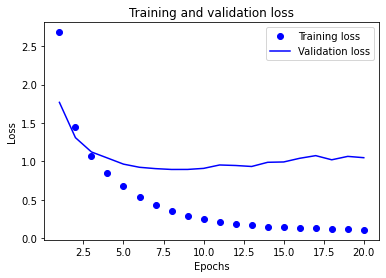

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting the training and validation accuracy

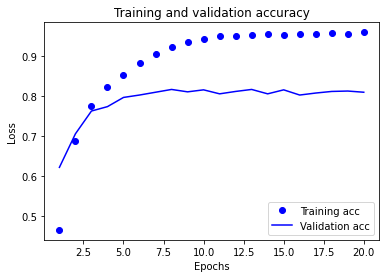

In [20]:
plt.clf() # Grafiği temizlemek için kullanılır

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Retraining a model from scratch

9. epochtan sonra model aşırı öğrenmeye başlıyor. Bu nedenle 9 epochluk bir model yazıp, test verisini tahmin edelim.

In [21]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Epoch 1/9
16/16 [==============================] - 1s 32ms/step - loss: 2.7207 - accuracy: 0.5421 - val_loss: 1.7610 - val_accuracy: 0.6370
Epoch 2/9
16/16 [==============================] - 0s 22ms/step - loss: 1.4534 - accuracy: 0.7040 - val_loss: 1.3190 - val_accuracy: 0.7120
Epoch 3/9
16/16 [==============================] - 0s 21ms/step - loss: 1.0787 - accuracy: 0.7720 - val_loss: 1.1409 - val_accuracy: 0.7650
Epoch 4/9
16/16 [==============================] - 0s 21ms/step - loss: 0.8558 - accuracy: 0.8181 - val_loss: 1.0488 - val_accuracy: 0.7680
Epoch 5/9
16/16 [==============================] - 0s 21ms/step - loss: 0.6826 - accuracy: 0.8555 - val_loss: 0.9745 - val_accuracy: 0.7940
Epoch 6/9
16/16 [==============================] - 0s 22ms/step - loss: 0.5471 - accuracy: 0.8876 - val_loss: 0.9259 - val_accuracy: 0.8060
Epoch 7/9
16/16 [==============================] - 0s 21ms/step - loss: 0.4370 - accuracy: 0.9102 - val_loss: 0.9117 - val_accuracy: 0.8030
Epoch 8/9
16/16 [===

[1.0019371509552002, 0.7787176966667175]

%78 doğruluk elde ettim

Random bir şekilde tahmin yapsaydım...

In [22]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1829919857524488

Doğruluk payım %17 olurdu. Bu da modelin bir şeyler öğrendiğinin kanıtıdır.

# Generating predictions on new data

In [23]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [24]:
predictions[0]

array([1.55653725e-05, 1.26933402e-04, 1.04935789e-05, 9.90549624e-01,
       5.22090960e-03, 2.47524513e-05, 6.13859811e-06, 2.18525875e-05,
       3.18736711e-04, 1.02832528e-04, 2.15654163e-05, 1.43057900e-04,
       9.31740142e-05, 1.80755756e-04, 1.23123300e-05, 1.02054018e-05,
       1.08489709e-04, 2.04958502e-04, 1.66950031e-05, 3.97642958e-04,
       1.67648715e-03, 4.20237811e-05, 4.34422333e-07, 1.46924440e-05,
       1.33219992e-05, 5.08586745e-05, 1.39291778e-05, 1.27610119e-05,
       6.91936884e-06, 1.19968914e-04, 2.06746445e-05, 3.65630913e-05,
       1.89562761e-05, 8.57648502e-06, 4.70985287e-05, 2.94292840e-06,
       1.15772295e-04, 1.27009007e-05, 6.62791899e-06, 1.74703200e-05,
       1.27207881e-04, 1.13935084e-05, 3.74441356e-06, 3.18592652e-06,
       2.61681689e-05, 2.51265828e-06], dtype=float32)

In [25]:
np.sum(predictions[0])

0.9999996

In [26]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

In [27]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

Etiketleri One hot encoding kullanmadan alacak olursak __categorical_crossentropy__ yerine __sparse_categorical_entropy__ kullanmalıyız. Her ikisi de matematiksel olarak aynıdır.

In [28]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [29]:
print("Train")
model.fit(x_train,
          train_labels,
          epochs=9,
          batch_size=512)
print("Test")
results = model.evaluate(x_test, test_labels)
results

Train
Epoch 1/9
18/18 [==============================] - 0s 18ms/step - loss: 0.3430 - acc: 0.9234
Epoch 2/9
18/18 [==============================] - 0s 18ms/step - loss: 0.2504 - acc: 0.9412
Epoch 3/9
18/18 [==============================] - 0s 18ms/step - loss: 0.2118 - acc: 0.9469
Epoch 4/9
18/18 [==============================] - 0s 18ms/step - loss: 0.1924 - acc: 0.9483
Epoch 5/9
18/18 [==============================] - 0s 18ms/step - loss: 0.1676 - acc: 0.9527
Epoch 6/9
18/18 [==============================] - 0s 19ms/step - loss: 0.1566 - acc: 0.9532
Epoch 7/9
18/18 [==============================] - 0s 19ms/step - loss: 0.1497 - acc: 0.9522
Epoch 8/9
18/18 [==============================] - 0s 18ms/step - loss: 0.1350 - acc: 0.9536
Epoch 9/9
18/18 [==============================] - 0s 18ms/step - loss: 0.1306 - acc: 0.9549
Test
71/71 [==============================] - 0s 2ms/step - loss: 1.1715 - acc: 0.7943


[1.1715031862258911, 0.7943009734153748]

%79 başarı

### A model with an information bottleneck

Katmanda 64 yerine 4 kullanırsak ne olur?

In [32]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 12ms/step - loss: 3.4088 - accuracy: 0.0901 - val_loss: 3.0384 - val_accuracy: 0.1350
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2.5349 - accuracy: 0.2637 - val_loss: 2.2138 - val_accuracy: 0.2740
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7028 - accuracy: 0.5076 - val_loss: 1.5606 - val_accuracy: 0.5900
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.3254 - accuracy: 0.6290 - val_loss: 1.4497 - val_accuracy: 0.6410
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.1836 - accuracy: 0.6769 - val_loss: 1.4084 - val_accuracy: 0.6540
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0882 - accuracy: 0.6929 - val_loss: 1.4106 - val_accuracy: 0.6570
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0144 - accuracy: 0.7144 - val_loss: 1.4074 - val_accuracy: 0.6740
Epoch 8/20
63

Birçok veriyi 4 nöronda topladık ve sonrasında 46 sınıfa ayırmaya çalıştık. Makinenin bunu ayrıştırması imkansız olduğundan 
doğruluk %8 düştü.

In [37]:
a = [1,2,3]
b = ["a","b","c"]
for i,j in zip(a,b):
    print(i,j)

1 a
2 b
3 c


Katman Sayısı:3
Dense Sayisi:8
Batch size:128
Aktivasyon fonksiyonu:relu


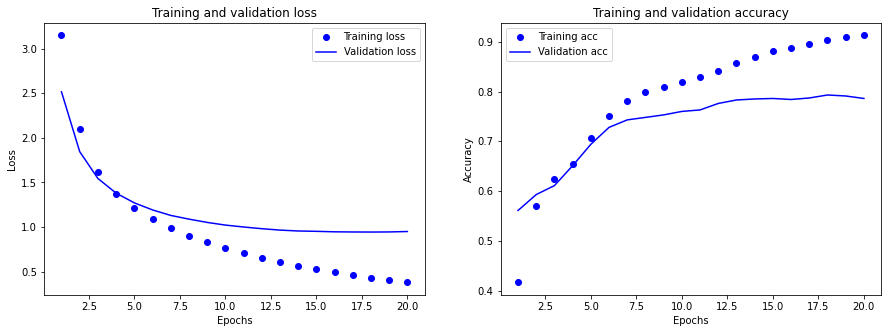

Başarı:  0.767141580581665
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:8
Batch size:128
Aktivasyon fonksiyonu:tanh


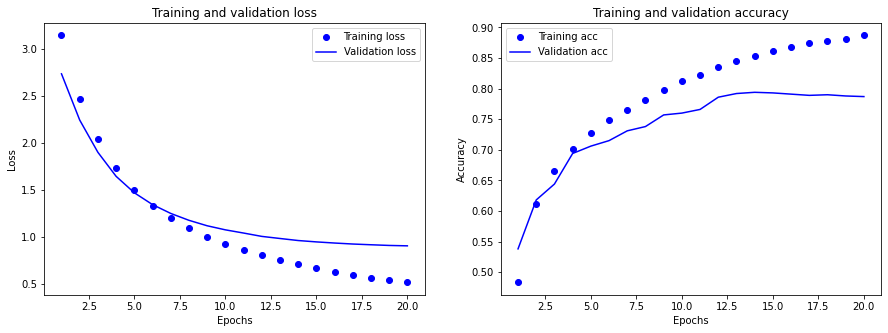

Başarı:  0.7707034945487976
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:8
Batch size:1024
Aktivasyon fonksiyonu:relu


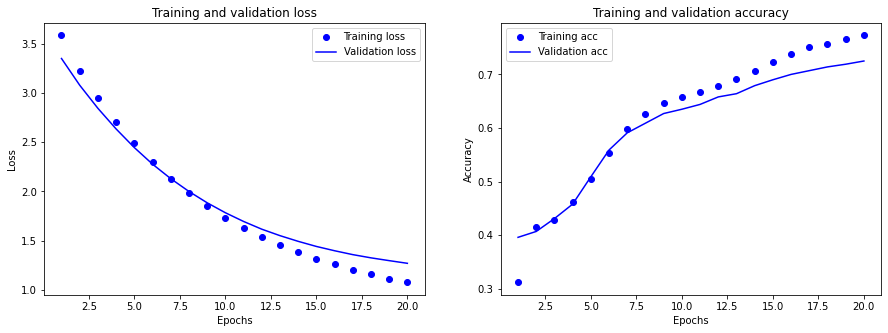

Başarı:  0.707034707069397
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:8
Batch size:1024
Aktivasyon fonksiyonu:tanh


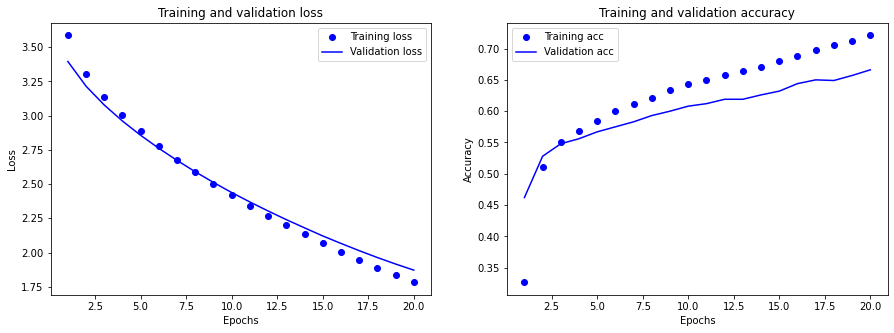

Başarı:  0.6665182709693909
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:64
Batch size:128
Aktivasyon fonksiyonu:relu


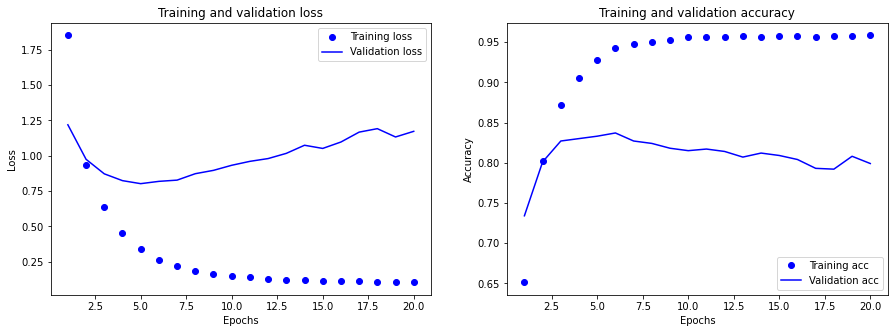

Başarı:  0.7916295528411865
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:64
Batch size:128
Aktivasyon fonksiyonu:tanh


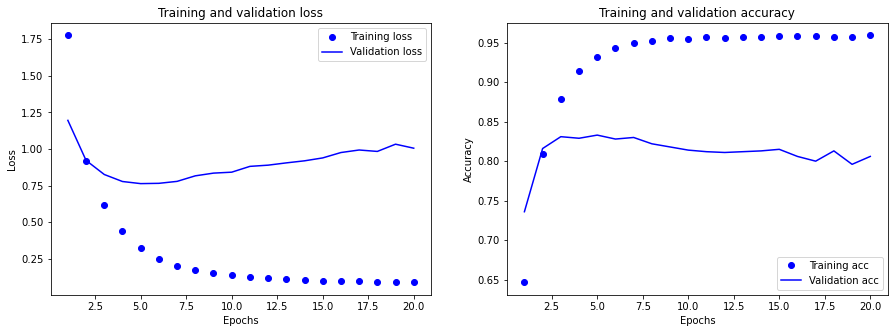

Başarı:  0.7867319583892822
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:64
Batch size:1024
Aktivasyon fonksiyonu:relu


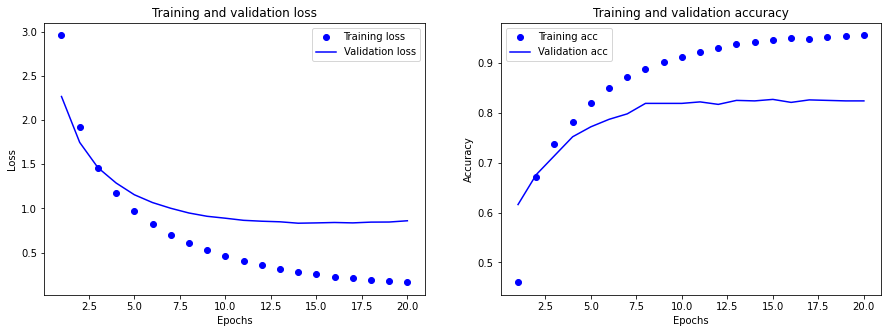

Başarı:  0.7943009734153748
---------------------------------------------------------------------------------------
Katman Sayısı:3
Dense Sayisi:64
Batch size:1024
Aktivasyon fonksiyonu:tanh


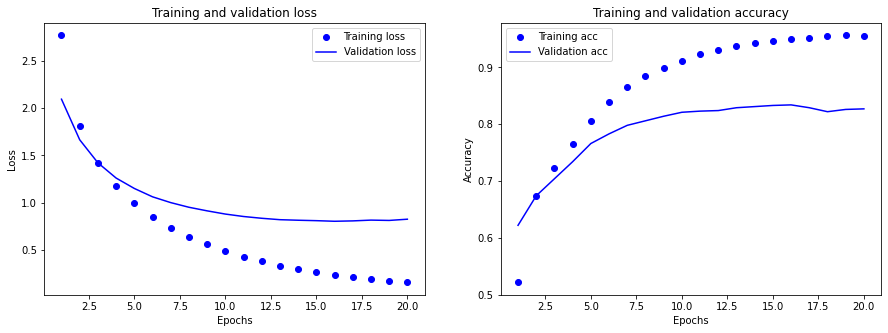

Başarı:  0.800979495048523
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:8
Batch size:128
Aktivasyon fonksiyonu:relu


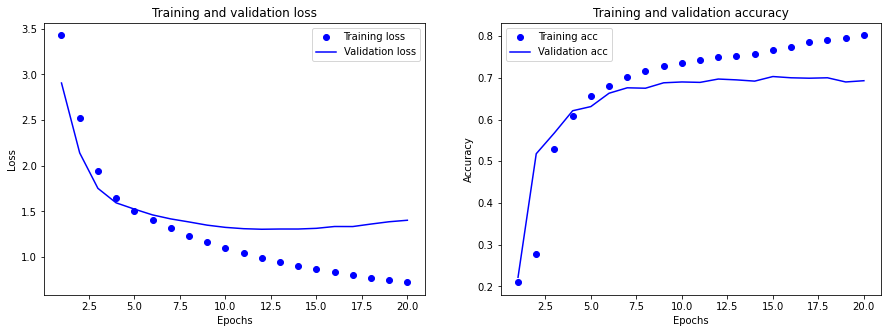

Başarı:  0.6776491403579712
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:8
Batch size:128
Aktivasyon fonksiyonu:tanh


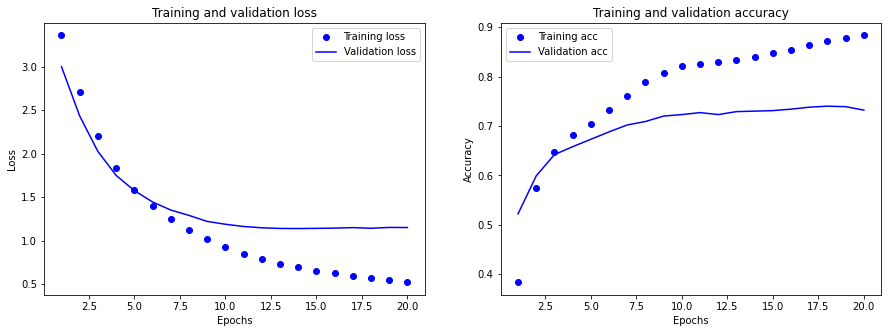

Başarı:  0.7217274904251099
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:8
Batch size:1024
Aktivasyon fonksiyonu:relu


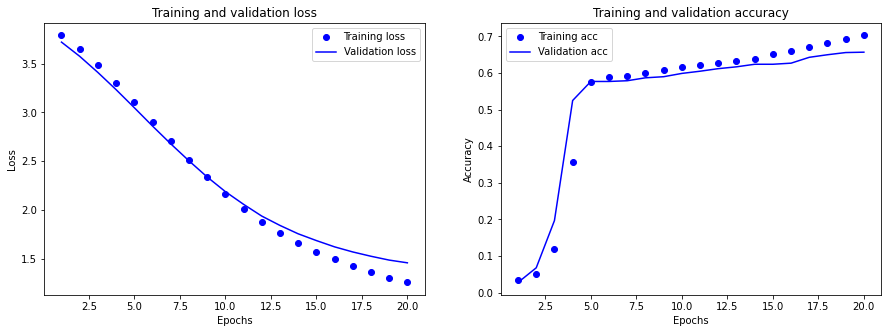

Başarı:  0.6553873419761658
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:8
Batch size:1024
Aktivasyon fonksiyonu:tanh


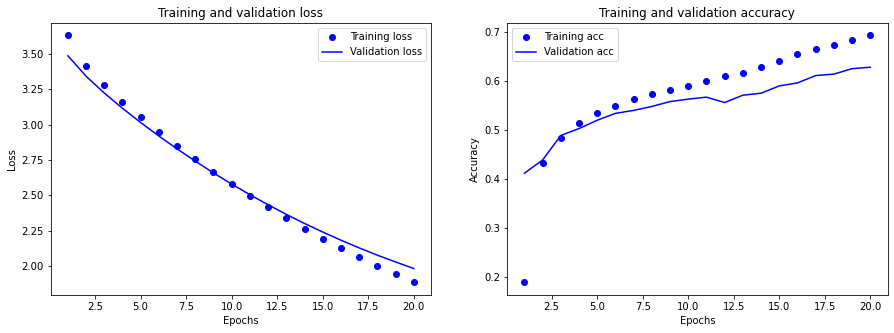

Başarı:  0.6255565285682678
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:64
Batch size:128
Aktivasyon fonksiyonu:relu


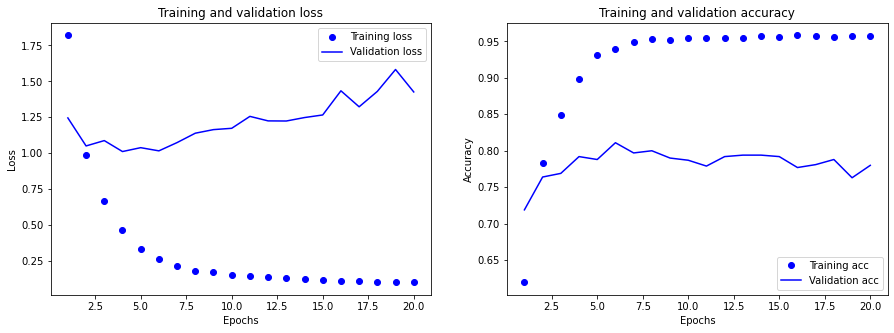

Başarı:  0.7707034945487976
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:64
Batch size:128
Aktivasyon fonksiyonu:tanh


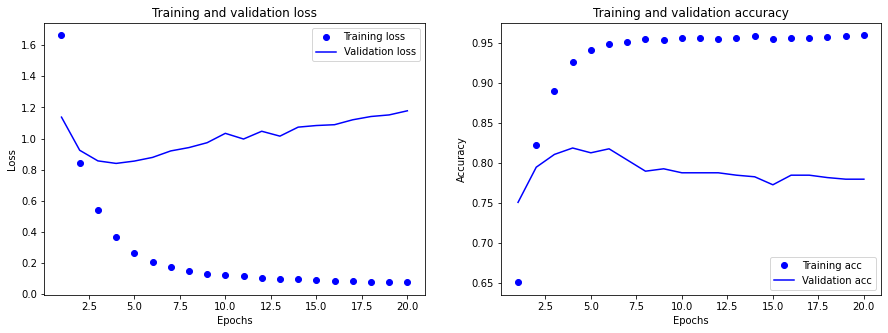

Başarı:  0.7684773206710815
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:64
Batch size:1024
Aktivasyon fonksiyonu:relu


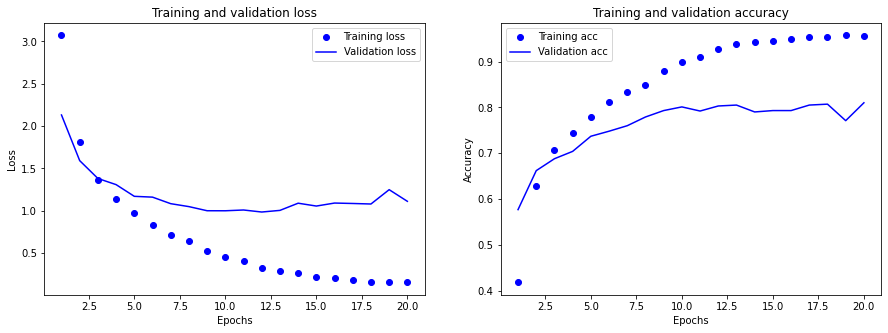

Başarı:  0.7827248573303223
---------------------------------------------------------------------------------------
Katman Sayısı:5
Dense Sayisi:64
Batch size:1024
Aktivasyon fonksiyonu:tanh


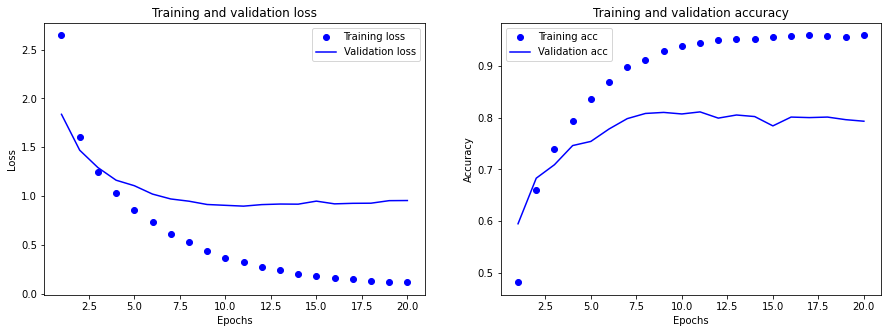

Başarı:  0.7769367694854736
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:8
Batch size:128
Aktivasyon fonksiyonu:relu


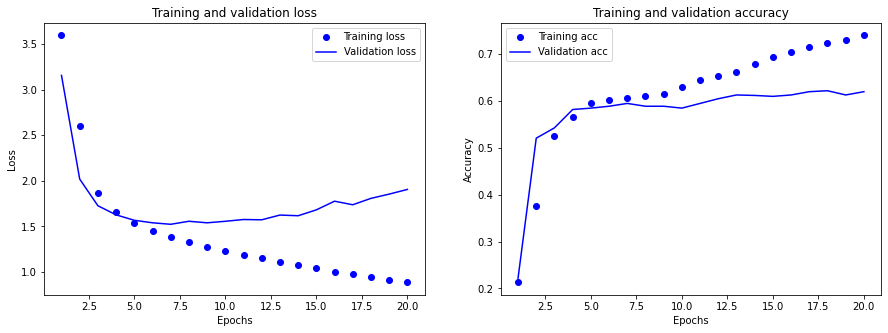

Başarı:  0.628227949142456
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:8
Batch size:128
Aktivasyon fonksiyonu:tanh


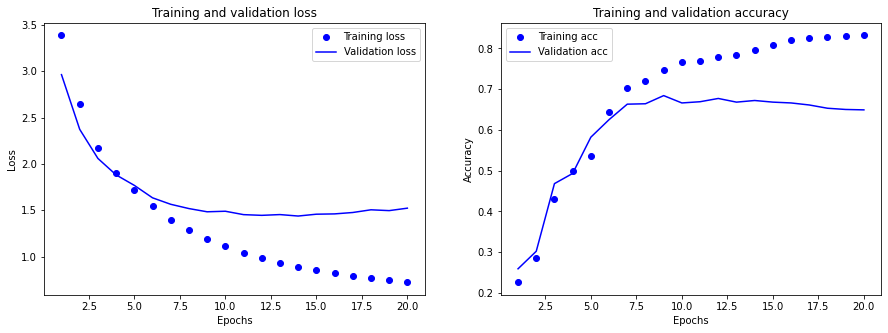

Başarı:  0.6607301831245422
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:8
Batch size:1024
Aktivasyon fonksiyonu:relu


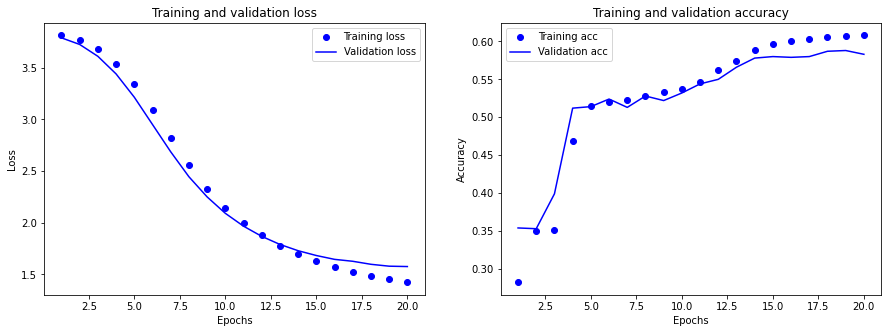

Başarı:  0.5796972513198853
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:8
Batch size:1024
Aktivasyon fonksiyonu:tanh


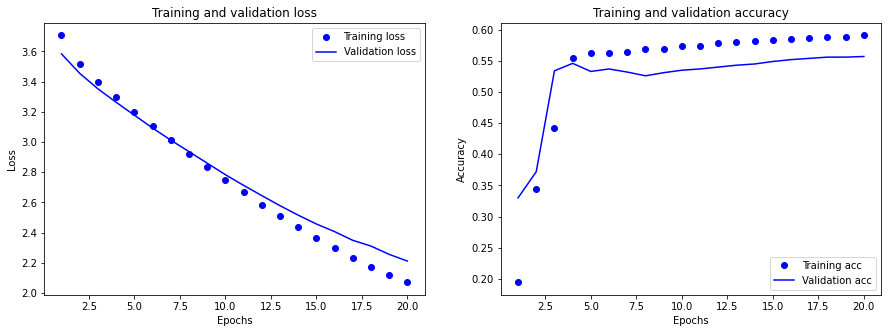

Başarı:  0.561887800693512
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:64
Batch size:128
Aktivasyon fonksiyonu:relu


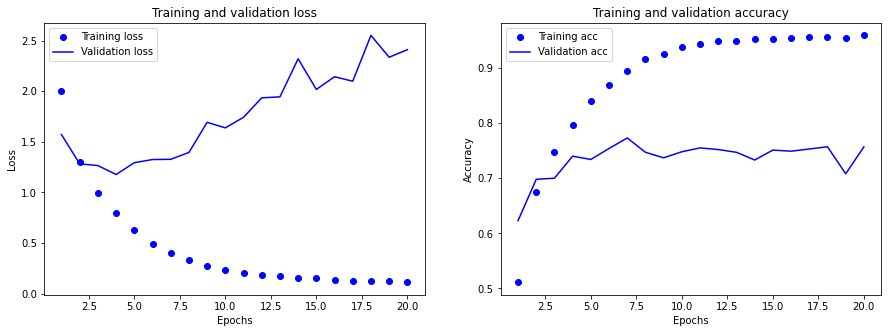

Başarı:  0.7382012605667114
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:64
Batch size:128
Aktivasyon fonksiyonu:tanh


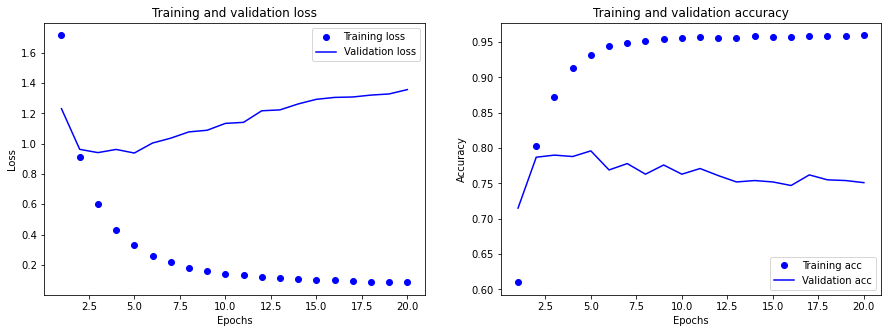

Başarı:  0.7466607093811035
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:64
Batch size:1024
Aktivasyon fonksiyonu:relu


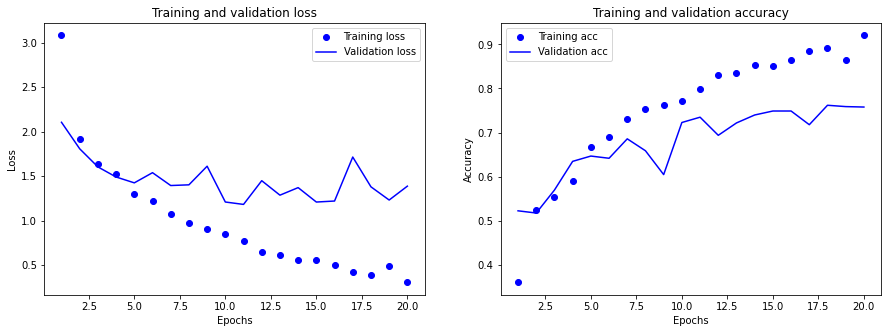

Başarı:  0.7524487972259521
---------------------------------------------------------------------------------------
Katman Sayısı:9
Dense Sayisi:64
Batch size:1024
Aktivasyon fonksiyonu:tanh


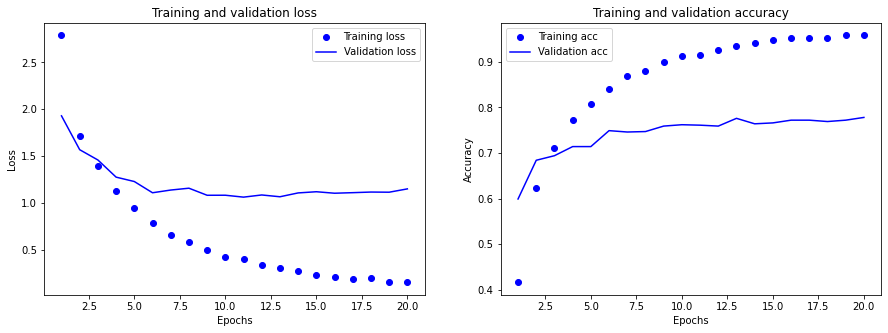

Başarı:  0.7488868832588196
---------------------------------------------------------------------------------------


In [46]:
for katmanSayisi in [0, 2, 6]:
    for denseSayisi in [8, 64]:
        for batchSize in [128,1024]:
            for aktivasyonFonk in ["relu","tanh"]:
                print(f"Katman Sayısı:{katmanSayisi+3}\nDense Sayisi:{denseSayisi}\nBatch size:{batchSize}\nAktivasyon fonksiyonu:{aktivasyonFonk}")
                model = models.Sequential()
                model.add(layers.Dense(denseSayisi, activation=aktivasyonFonk, input_shape=(10000,)))
                for i in range(katmanSayisi):
                    model.add(layers.Dense(denseSayisi, activation=aktivasyonFonk))
                model.add(layers.Dense(46, activation='softmax'))
                model.compile(optimizer='rmsprop',
                          loss="categorical_crossentropy",
                          metrics=['accuracy'])
                history = model.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=batchSize,
                      validation_data=(x_val, y_val),
                      verbose = 0)

                history_dict = history.history

                plt.figure(figsize=(15,5))
                plt.subplot(1,2,1)
                history_dict = history.history
                loss_values = history_dict['loss']
                val_loss_values = history_dict['val_loss']

                acc = history_dict["accuracy"]

                epochs = range(1, len(acc) + 1)

                plt.plot(epochs, loss_values, 'bo', label='Training loss') 
                plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
                plt.title('Training and validation loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()

                plt.subplot(1,2,2)

                val_acc = history_dict['val_accuracy']
                plt.plot(epochs, acc, 'bo', label='Training acc')
                plt.plot(epochs, val_acc, 'b', label='Validation acc')
                plt.title('Training and validation accuracy')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.show()

                print("Başarı: ",model.evaluate(x_test,one_hot_test_labels,verbose = 0)[1])
                print("---------------------------------------------------------------------------------------")